In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm

# Data Pipeline

## How datasets are joined

### Movie dataset and Character dataset
We join the two datasets on the `freebase_movie_id`.

### Character dataset and Oscar dataset
Oscar dataset does not have `freebase_movie_id` or `freebase_actor_id`. We instead use `parsed_actor_name` and `movie_identifier`. `parsed_actor_name` will be unique for each movie as we drop actors if they share `parsed_actor_name` from playing another character in the same movie. `movie_identifier` is a combination of `parsed_movie_name` and `release_year`. This is unique as we drop movies that share `movie_identifier`.

### Resulting dataset from previous steps and IMDb dataset
We join these datasets using a combination of `parsed_movie_name` and `release_year` as primary key.
<br><br><br>
The resulting dataset after the entire pipeline is run is written to `cache/data.csv`, ready for use in P3.

In [2]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36758
Oscar nominated movies with rating: 939
Processing done, dataset written to cache/data.csv


In [3]:
movie_df = pd.read_csv('cache/data.csv', sep=',', index_col=0)

In [4]:
movie_df.head()

,title,release_date,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,...,parsed_actor_name,actor_identifier,identifier,category,winner,oscar_nominated,year,has_rating,average_rating,number_of_votes
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,M,1.727,...,ice cube,/m/01vw26l,ghosts of mars_2001_ice cube,NaN,NaN,False,2001.0,True,4.9,58876.0
1,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,F,1.650,...,clea duvall,/m/01y9xg,ghosts of mars_2001_clea duvall,NaN,NaN,False,2001.0,True,4.9,58876.0
2,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,M,NaN,...,robert carradine,/m/026qxz,ghosts of mars_2001_robert carradine,NaN,NaN,False,2001.0,True,4.9,58876.0
3,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,M,NaN,...,doug mcgrath,/m/02r5d3j,ghosts of mars_2001_doug mcgrath,NaN,NaN,False,2001.0,True,4.9,58876.0
4,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,F,1.780,...,natasha henstridge,/m/0346l4,ghosts of mars_2001_natasha henstridge,NaN,NaN,False,2001.0,True,4.9,58876.0


## Descriptive statistics and data limitations

### NaN-values

In [5]:
print('Percentage of NaN values in each column:')
movie_df.isnull().sum() * 100 / len(movie_df)

Percentage of NaN values in each column:


title                  0.000000
release_date           2.185775
box_office_revenue    77.560744
runtime               11.133158
languages              0.000000
countries              0.000000
genres                 0.000000
movie_identifier       0.000000
actor_gender           9.946697
actor_height          65.646082
actor_ethnicity       76.545646
actor_name             0.000000
actor_age             34.990665
parsed_actor_name      0.000000
actor_identifier       0.000000
identifier             0.000000
category              99.674637
winner                99.674637
oscar_nominated        0.000000
year                   2.189157
has_rating             0.000000
average_rating        33.245698
number_of_votes       33.245698
dtype: float64

Some columns are critical, yet have high share of NaN values, e.g. actor_ethnicity and box_office_revenue 

We have asked TAs for input on how to handle these values, we see two options:
1. Make a fully cleaned dataset with no NaNs
2. Have different subsets of data for different analysis questions

Two columns are specific to rows that have been Oscar nominated (category, winner). It is therefore no problem that they have many NaN values.

We examine how much of the data would be lost if we drop all rows with NaN-values in relevant columns:

In [6]:
print(f'Number of data points before dropping NaN values: {len(movie_df)}')

Number of data points before dropping NaN values: 443504


In [7]:
data_points_after_drop = len(movie_df.dropna(subset=['title', 'release_date', 'box_office_revenue', 'runtime', 'languages',
       'countries', 'genres', 'movie_identifier', 'actor_gender',
       'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age',
       'parsed_actor_name', 'actor_identifier', 'identifier','year', 'has_rating', 'average_rating',
       'number_of_votes']))

print(f'Number of complete data points we would have if we dropped all NaN values in relevant columns: {data_points_after_drop}')

Number of complete data points we would have if we dropped all NaN values in relevant columns: 23819


We see that a significant portion of the data (~95%) would be lost by removing rows with relevant NaN-values.

### Correlation

In [8]:
cols = ['oscar_nominated', 'number_of_votes', 'average_rating', 'actor_height', 'runtime', 'box_office_revenue']
numerical_df = movie_df[cols].dropna()
print('Nr. of datapoints in the correlation analysis', len(numerical_df))
numerical_df.corr(method='pearson')

Nr. of datapoints in the correlation analysis 48580


,oscar_nominated,number_of_votes,average_rating,actor_height,runtime,box_office_revenue
oscar_nominated,1.000000,0.052176,0.153391,-0.002139,0.088175,0.004776
number_of_votes,0.052176,1.000000,0.459370,-0.000171,0.268943,0.659848
average_rating,0.153391,0.459370,1.000000,-0.003882,0.329811,0.229349
actor_height,-0.002139,-0.000171,-0.003882,1.000000,-0.000473,0.001798
runtime,0.088175,0.268943,0.329811,-0.000473,1.000000,0.221772
box_office_revenue,0.004776,0.659848,0.229349,0.001798,0.221772,1.000000


Most entries in the correlation matrix are positive. The ones that are negative are small. 

Below we analyze the p-value for the correlation to see between which relations it is significant and between which it is not. 

In [9]:
# Calculating p-values and storing them in the lists 'significant' and 'insignificant' depending on the test outcome. 
p_values_matrix = []
insignificant = []
significant = []
for col1 in cols: 
    p_values_list = []
    for col2 in cols: 
        if pearsonr(numerical_df[col1], numerical_df[col2])[1] > (0.05 / 30):  # 95% confidence level adjusted to bonferroni correction 
            insignificant.append((col1, col2))
        else: 
            significant.append((col1, col2))
            

# Printing findings: 
print(len(significant) - len(cols), 'entries in correlation matrix have significant p-value') # Removing self-correlation
print(len(insignificant), 'entries in correlation matrix have insignificant p-value')
print()

# Printing significant column pairs and skipping self-relations. 
print('Significant pairs: ')
for significant_pair in significant: 
    if significant_pair[0] != significant_pair[1]:
        print(significant_pair[0],'&', significant_pair[1])
print()
print()

# Printing insignificant column pairs
print('Insignificant pairs: ')
for insignificant_pair in insignificant: 
    print(insignificant_pair[0], '&', insignificant_pair[1])

18 entries in correlation matrix have significant p-value
12 entries in correlation matrix have insignificant p-value

Significant pairs: 
oscar_nominated & number_of_votes
oscar_nominated & average_rating
oscar_nominated & runtime
number_of_votes & oscar_nominated
number_of_votes & average_rating
number_of_votes & runtime
number_of_votes & box_office_revenue
average_rating & oscar_nominated
average_rating & number_of_votes
average_rating & runtime
average_rating & box_office_revenue
runtime & oscar_nominated
runtime & number_of_votes
runtime & average_rating
runtime & box_office_revenue
box_office_revenue & number_of_votes
box_office_revenue & average_rating
box_office_revenue & runtime


Insignificant pairs: 
oscar_nominated & actor_height
oscar_nominated & box_office_revenue
number_of_votes & actor_height
average_rating & actor_height
actor_height & oscar_nominated
actor_height & number_of_votes
actor_height & average_rating
actor_height & runtime
actor_height & box_office_revenue
r

The above result indicates that we believe 18 of 30 of the entries in the correlation matrix to be significant at the 95% level. 

# Country/nomination analysis

In [10]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(movie_df['countries'])
american_total_actors_num = len(movie_df[movie_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(movie_df[movie_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(movie_df[(movie_df['countries'].str.contains('United States of America')) & (movie_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [11]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

# We perform a two-sided hypothesis test for whether non-American actors have the same binomial probability of getting nominated as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

BinomTestResult(k=130, n=203152, alternative='two-sided', statistic=0.0006399149405371347, pvalue=2.6118071094409342e-307)

Using alpha=0.05. P-value=2.6118071094409342e-307 < 0.05. We can safely discard the null hypothesis that these have the same probability distribution, and conclude that there is a significantly different probability of being nominated for an Oscar for American and non-American actors.

In [12]:
print('Fraction of American actors nominated for an Oscar:',round(p_american, 5))
print('Fraction of non-American actors nominated for an Oscar:', round(p_non_american, 5))

Fraction of American actors nominated for an Oscar: 0.00546
Fraction of non-American actors nominated for an Oscar: 0.00064


We see that the observed probability of being nominated is higher for actors in American movies. We believe based on this analysis that the Oscar nominations are generally skewed with higher chances for actors in American movies.

# Logistic regression on movie and actor traits

In [13]:
movie_df.columns

Index(['title', 'release_date', 'box_office_revenue', 'runtime', 'languages',
       'countries', 'genres', 'movie_identifier', 'actor_gender',
       'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age',
       'parsed_actor_name', 'actor_identifier', 'identifier', 'category',
       'winner', 'oscar_nominated', 'year', 'has_rating', 'average_rating',
       'number_of_votes'],
      dtype='object')

In [14]:
# Finding the most common ethnicities
movie_df.groupby('actor_ethnicity').count().sort_values(by='title', ascending=False).head(15)

,title,release_date,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,...,parsed_actor_name,actor_identifier,identifier,category,winner,oscar_nominated,year,has_rating,average_rating,number_of_votes
actor_ethnicity,,,,,,,,,,,,,,,,,,,,,
/m/0dryh9k,16000,15167,176,9492,16000,16000,16000,16000,16000,6067,...,16000,16000,16000,3,3,16000,15167,16000,11029,11029
/m/0x67,10065,9933,4737,9667,10065,10065,10065,10065,10055,6476,...,10065,10065,10065,51,51,10065,9933,10065,7296,7296
/m/041rx,9758,9508,3797,8916,9758,9758,9758,9758,9758,7162,...,9758,9758,9758,104,104,9758,9508,9758,6778,6778
/m/02w7gg,6027,5893,2564,5708,6027,6027,6027,6027,6027,5114,...,6027,6027,6027,55,55,6027,5893,6027,4276,4276
/m/033tf_,3814,3775,1831,3684,3814,3814,3814,3814,3814,3448,...,3814,3814,3814,57,57,3814,3775,3814,2961,2961
/m/0xnvg,2927,2883,1533,2815,2927,2927,2927,2927,2927,2828,...,2927,2927,2927,52,52,2927,2883,2927,2233,2233
/m/02ctzb,2279,2237,847,2127,2279,2279,2279,2279,2278,1594,...,2279,2279,2279,21,21,2279,2237,2279,1489,1489
/m/07hwkr,2231,2196,1026,2130,2231,2231,2231,2231,2231,2023,...,2231,2231,2231,36,36,2231,2196,2231,1666,1666
/m/07bch9,2197,2173,733,1850,2197,2197,2197,2197,2197,1803,...,2197,2197,2197,34,34,2197,2173,2197,1373,1373


In [15]:
# The most frequent ethnicities, in descending order.
# Found the mappings manually, by looking the Freebase ethnicity ids up.

# An alternate solution would probably be to download a Freebase data dump and join using that.
# However, the dataset is quite large so we chose to go this route instead.
ethnicity_map = {    
    'Indian' : '/m/0dryh9k',
    'Black' : '/m/0x67',
    'Jewish' : '/m/041rx', 
    'English' : '/m/02w7gg',
    'Irish_Americans' : '/m/033tf_',
    'Italian_Americans' : '/m/0xnvg',
    'White_people' : '/m/02ctzb',
    'White_Americans' : '/m/07hwkr',
    'Scottish_Americans': '/m/07bch9',
    # '???' : '/m/044038p', Could not find what this Freedbase id maps to
    'Irish_people' : '/m/03bkbh',
    'British' : '/m/0d7wh',
    'French' : '/m/03ts0c',
    'Italians' : '/m/0222qb',
    'Tamil' : '/m/01rv7x',   
}

In [16]:
# We normalize the data before performing logistic regression
def normalize_column(df_column):
    return (df_column - df_column.mean()) / df_column.std()

In [17]:
normalized_movie_df = movie_df.copy(deep=True)
features_to_normalize = ['actor_age', 'box_office_revenue', 'runtime', 'actor_height', 'year', 'average_rating', 'number_of_votes',]
normalized_movie_df[features_to_normalize] = normalized_movie_df[features_to_normalize].apply(normalize_column)

# Encode oscar_nominated as 0 or 1 for logistic regression
normalized_movie_df['oscar_nominated'] = normalized_movie_df['oscar_nominated'].astype(int)

# One-hot encoding the 5 most frequent ethnicities for the logistic regression:
ethnicities = list(ethnicity_map.keys())[:5]
for name in ethnicities:
    normalized_movie_df[name] = normalized_movie_df['actor_ethnicity'].map(lambda ethnicity: 1 if ethnicity == ethnicity_map[name] else 0)

In [18]:
# The following regression and plotting code was inspired and/or copied from the solution to exercise 4
# We perform logistic regression using a selection of relevant features from the dataframe
mod = smf.logit(formula='oscar_nominated ~  runtime + box_office_revenue + actor_height + \
                        actor_age + year + average_rating + number_of_votes + \
                        C(Indian) + C(Black) + C(Jewish) + C(English) + C(Irish_Americans)', data=normalized_movie_df)

In [19]:
# Fit the model and print results
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.069410
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:        oscar_nominated   No. Observations:                46882
Model:                          Logit   Df Residuals:                    46869
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.2183
Time:                        17:58:35   Log-Likelihood:                -3254.1
converged:                       True   LL-Null:                       -4162.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.3712      0.093    -57.583      0.000      -5.554  

c:\Users\johnh\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\johnh\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Note: we get the runtime warning as 1+np.exp(-X) gets so massive it is not computed properly. It does not have impact on the output which will be 0 anyways (division by a very large number).

In [20]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

,0,1
Intercept,-5.554048,-5.188402
C(Indian)[T.1],-0.375065,2.139532
C(Black)[T.1],-0.196781,0.530607
C(Jewish)[T.1],-0.110763,0.448978
C(English)[T.1],-0.194977,0.483673
C(Irish_Americans)[T.1],0.116992,0.845163
runtime,8.227059,30.498853
box_office_revenue,-0.040455,0.114526
actor_height,-13.923900,-8.218296
actor_age,0.265030,0.478024


In [21]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

Text(0.5, 1.0, 'Logistic regression coefficient by feature')

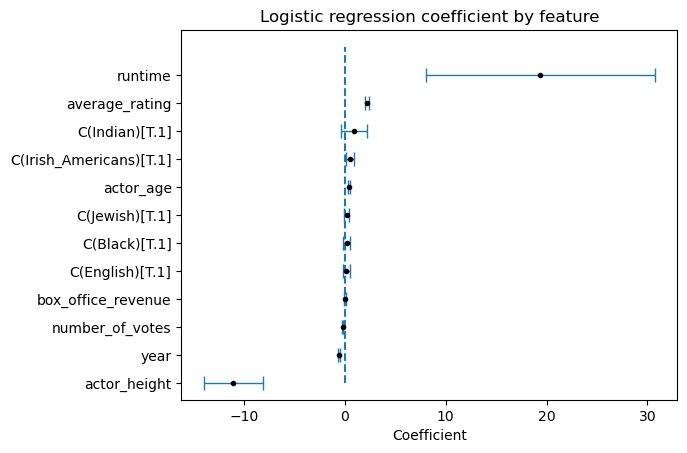

In [22]:
# Plot the results
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2)
plt.xlabel('Coefficient')
plt.title('Logistic regression coefficient by feature')

Lines around the points represent the confidence interval for the coefficient of each feature.

From this plot we see that there are multiple factors that can be used to predict whether a movie/actor row will be nominated or not. This serves as an initial analysis, we will do this more thoroughly in P3 to make more relevant conclusions for our research questions.

# Review analysis

To extract movies with nominated actors we need to find every movie where at least one of the rows in the column 'oscar_nominated' is positive.
To extract movies without a nominated actor we need to find every movie where every row in the column 'oscar_nominated' is false. 

In [23]:
# Grouping all movies by title, into unique_movies_df
unique_movies_df = movie_df.groupby('movie_identifier').first().reset_index()

print('Shape before: ', unique_movies_df.shape)
unique_nominated_movies_df = movie_df[movie_df['oscar_nominated'] == True].groupby('movie_identifier').first().reset_index()
# Mask is true if a movie from unique_movies_df is not in the dataframe unique_nominated_movies_df
mask = unique_movies_df['movie_identifier'].isin(unique_nominated_movies_df['movie_identifier']) == False

# Applying the mask 
not_nominated_df = unique_movies_df[mask]
# Checking the intersection between nominated and not nominated movies, should be 0 
print('Intersection between nominated and not nominated: ', pd.Series(list(set(unique_nominated_movies_df['movie_identifier']).intersection(set(not_nominated_df['movie_identifier'])))))

unique_movies_df = pd.concat([unique_nominated_movies_df, not_nominated_df], axis = 0) 
print('Shape after: ', unique_movies_df.shape)

Shape before:  (63968, 23)
Intersection between nominated and not nominated:  Series([], dtype: object)
Shape after:  (63968, 23)


Intersection is [], hence selection worked. 

In [24]:
# Removing movies without imdb ratings
movie_unique_with_rating_df = unique_movies_df[unique_movies_df['average_rating'].notna()]


In [25]:
print('Movies with oscar nominated actors with ratings: ', len(movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated'] == True]))

Movies with oscar nominated actors with ratings:  939


In [26]:
# Extracting nominated and movies and not nominated movies 
nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated']]
not_nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated'] == False]
assert nominated.shape[0] + not_nominated.shape[0] == movie_unique_with_rating_df.shape[0]

In [27]:
# We exclude all movies with fewer than 30 reviews. There are no movies with oscar nominated actors with fewer than 30 reviews.
# This is based on a rule of thumb to exclude outliers / low confidence values 
excluded = not_nominated[not_nominated['number_of_votes'] < 30]
print('Excluded nr of movies from analysis due to few reviews (< 30): ', len(excluded))
not_nominated = not_nominated[not_nominated['number_of_votes'] >= 30]
nominated = nominated[nominated['number_of_votes'] >= 30]

Excluded nr of movies from analysis due to few reviews (< 30):  2319


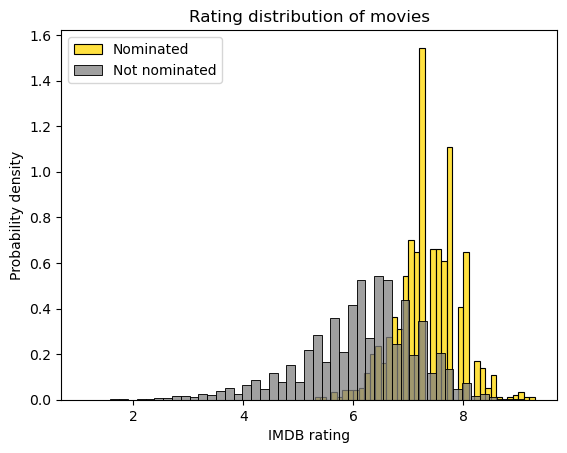

In [28]:
# Empirical CDF for nominated and not nominated 

sns.histplot(nominated, x="average_rating", stat = 'density', color = 'gold',label ='Nominated', bins =40)
sns.histplot(not_nominated, x="average_rating", stat="density", color = 'grey', label = 'Not nominated', bins = 50)

plt.title('Rating distribution of movies')
plt.xlabel('IMDB rating')
plt.ylabel('Probability density')
plt.legend()
plt.show()


These empirical distributions look different. We use a two sample Kolmogorov-Smirnov test to test if they are different. The null hypothesis is that the observations come from the same distribution. We reject the null hypothesis if the p-value < 0.05. Also we note that if the test statistic is 0 the distributions are identical and if the test statistic is 1 the distributions are completely different. 

In [29]:
stats.kstest(nominated['average_rating'], not_nominated['average_rating'])

KstestResult(statistic=0.5496403287078983, pvalue=1.6450047550532477e-259, statistic_location=6.8, statistic_sign=-1)

Test statistic is 0.55, meaning distributions are different but not completely diffent. 
P-value = 1.6450047550532477e-259. This is extremely small, we can safely reject the null hypothesis. The conclusion is that the distributions are in fact different distributions. 

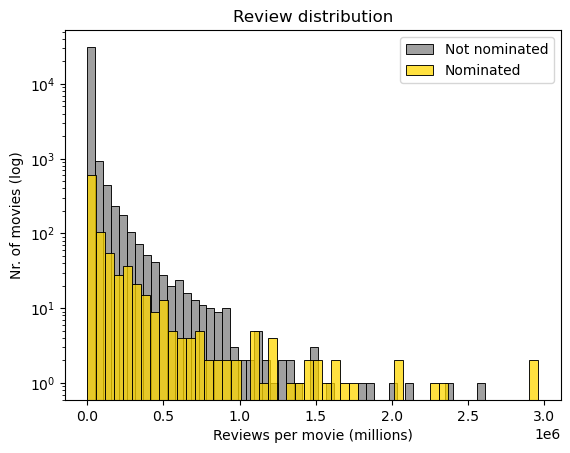

In [30]:
# Plotting reviews per IMDB reviews per movie 
sns.histplot(not_nominated, x="number_of_votes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(nominated, x="number_of_votes", bins=50, label = 'Nominated', color = 'gold')
plt.yscale('log')
plt.title('Review distribution')
plt.xlabel('Reviews per movie (millions)')
plt.ylabel('Nr. of movies (log)')
plt.legend()
plt.show()

In [31]:
stats.kstest(not_nominated['number_of_votes'], nominated['number_of_votes'])

KstestResult(statistic=0.5566385007868009, pvalue=8.954348690957251e-267, statistic_location=4296.0, statistic_sign=1)

Share of not nominated movies with fewer than 10 000 reviews: 82.74 %
Share of nominated with fewer than 10 000 reviews: 33.55 %


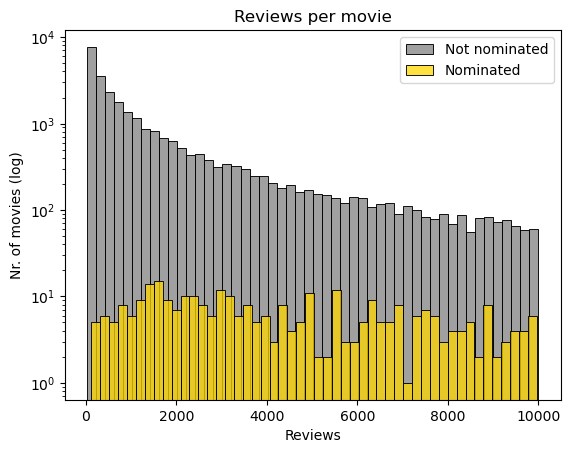

In [32]:
# As per the plot above, most movies with nominated actors have fewer than 500 000 reviews.
# We zoom in and look at the movies with few reviews. 

lim_not_nominated = not_nominated[not_nominated['number_of_votes'] < 10000]
lim_nominated = nominated[nominated['number_of_votes'] < 10000]

print('Share of not nominated movies with fewer than 10 000 reviews:', round(len(lim_not_nominated)/len(not_nominated)*100,2), '%')
print('Share of nominated with fewer than 10 000 reviews:', round(len(lim_nominated)/(len(nominated))*100,2),  '%')

sns.histplot(lim_not_nominated, x="number_of_votes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(lim_nominated, x="number_of_votes", bins=50, label = 'Nominated', color = 'gold')

plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies (log)')
plt.legend()
plt.show()

We can see that most movies with relatively few review are not nominated. 

## Box-Office Revenue

Note: we will inflation adjust box-office revenues in P3 for higher accuracy. 

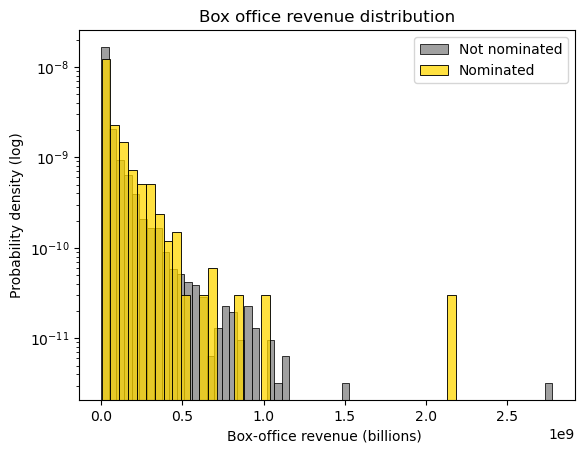

In [33]:
sns.histplot(not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 40)

plt.title('Box office revenue distribution')
plt.yscale('log')
plt.xlabel('Box-office revenue (billions) ')
plt.ylabel('Probability density (log)')
plt.legend()
plt.show()

Notice that the above plot is a probability distribution and that the y axis is in log scale. We are suprised since all movies with nominated actors do not seem to be the ones with the highest revenue. To investigate this we look into movies with lower box-office revenue. 

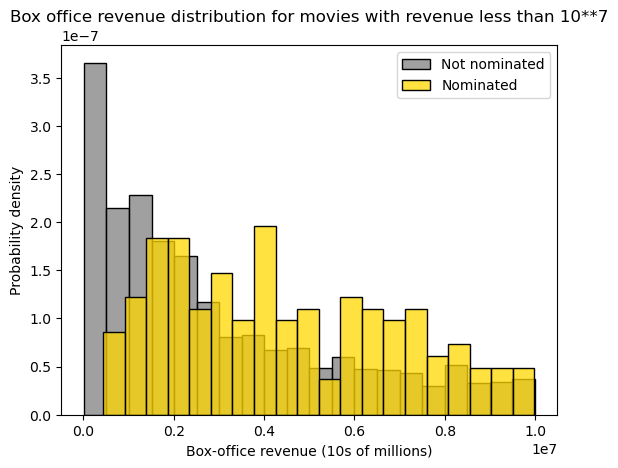

In [34]:
lim_not_nominated = not_nominated[not_nominated['box_office_revenue'] < 10**7]
lim_nominated = nominated[nominated['box_office_revenue'] < 10**7]

sns.histplot(lim_not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 20)
sns.histplot(lim_nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 20)

plt.title('Box office revenue distribution for movies with revenue less than 10**7')
plt.xlabel('Box-office revenue (10s of millions)')
plt.ylabel('Probability density')
plt.legend()
plt.show()


We can see that movies with nominated actors have revenue in an interval. They are neither the movies with the highest revenue, or the movies with the lowest revenue. We think this will be a hypothesis to explore further in P3. 